In [25]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
import numpy as np

In [26]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns = {'GDP (current US$)':'GDP'}, inplace = True )
data

,GDP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


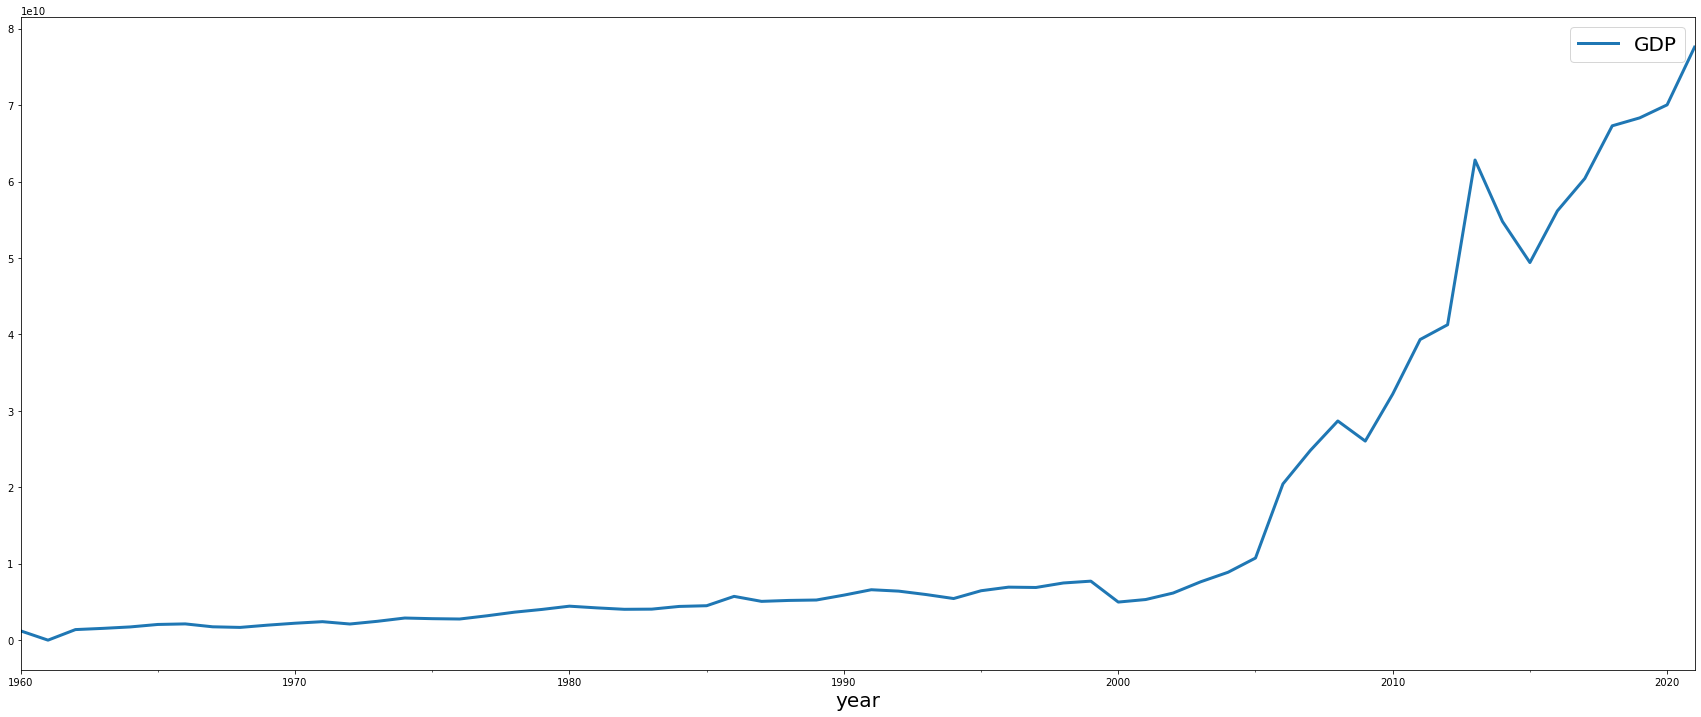

In [27]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [28]:
train_df = data.loc[:"2019-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((60, 1), (3, 1))

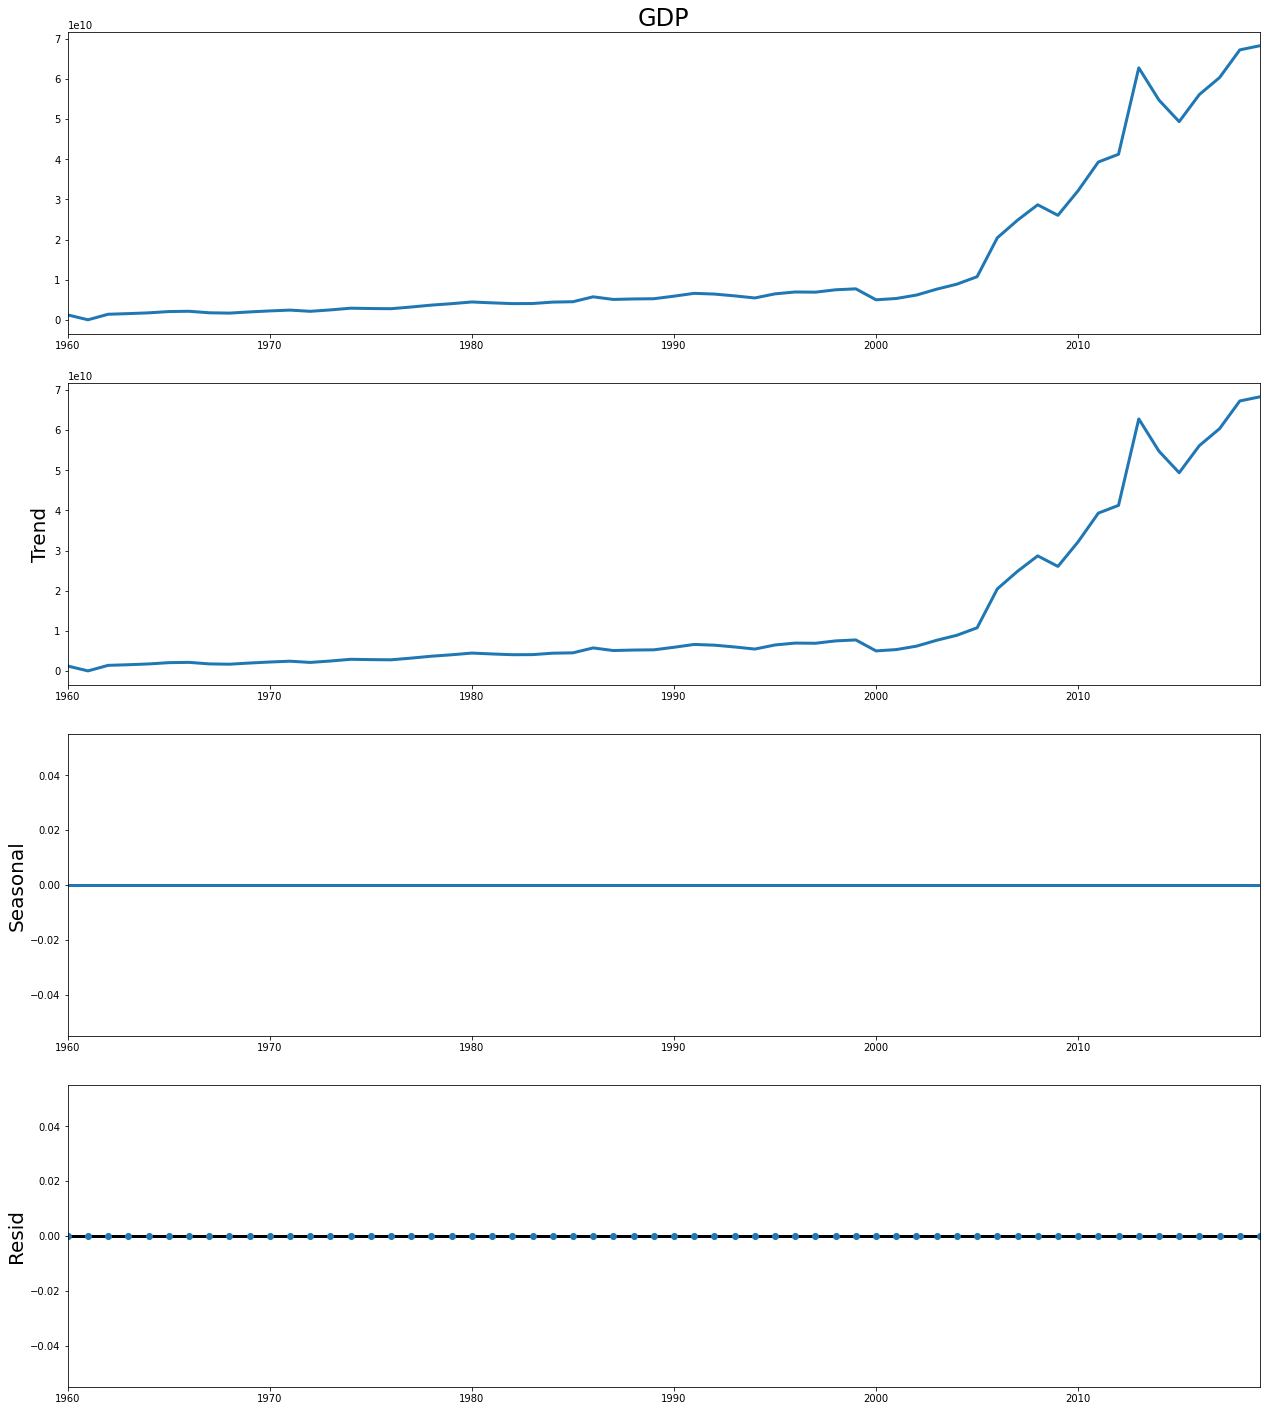

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.GDP)
result.plot()
plt.show()

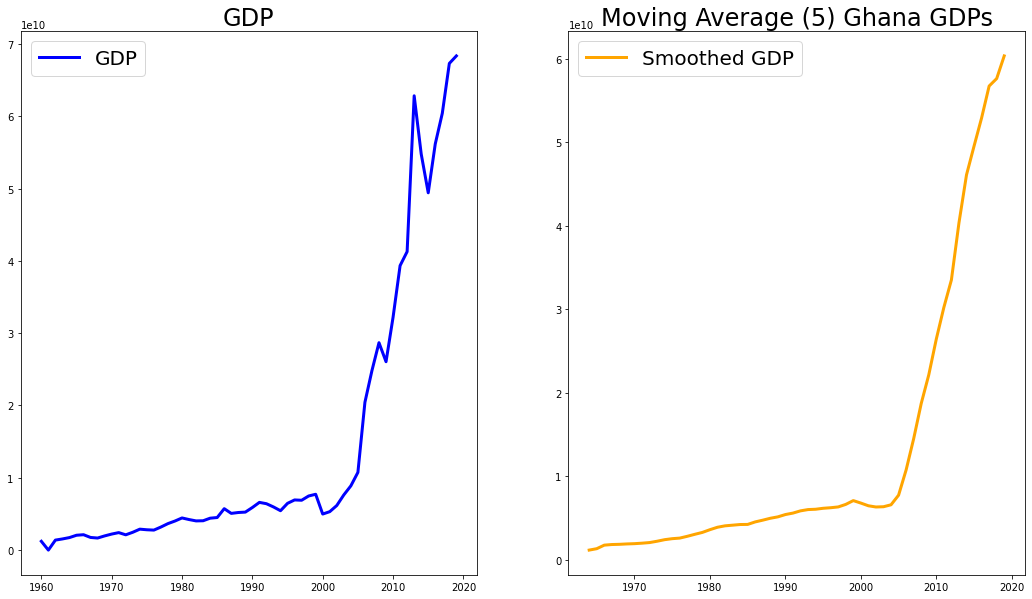

In [30]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(1,2)

# Окно в месяц (Window = 2)
ax[0].plot(train_df.GDP, color="blue", label="GDP")
ax[0].set_title("GDP", size=24)
ax[0].legend()

ax[1].plot(
    train_df.GDP.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)

ax[1].set_title("Moving Average (5) Ghana GDPs", size=24)
ax[1].legend()


plt.show()

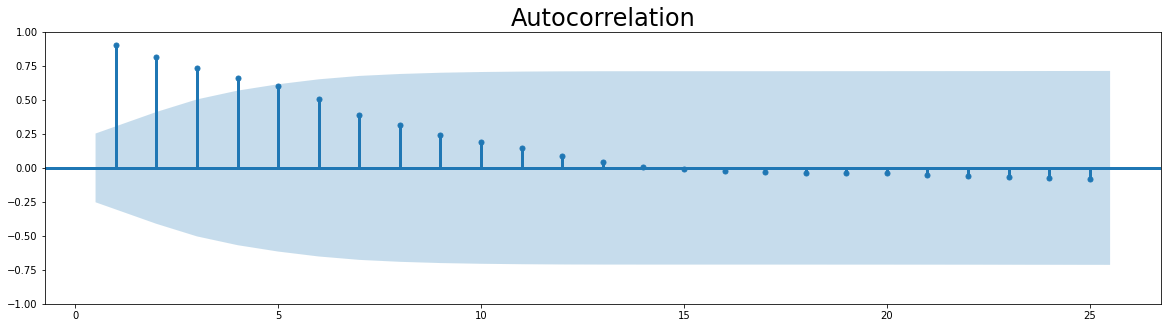

In [31]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.GDP, lags=25, zero=False)
plt.show()

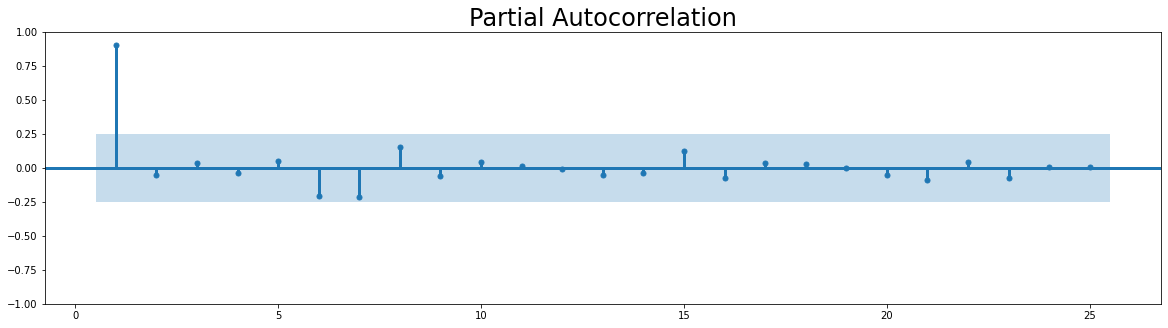

In [32]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.GDP, lags=25, method="ywm", zero=False)
plt.show()

In [33]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["GDP"])

(0.5782902144237625,
 0.9870681153049116,
 10,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2239.7989988859235)

In [34]:
test1 = adfuller(train_df["GDP"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.5782902144237625
p-value:  0.9870681153049116
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому GDP Ганы не являются стационарными

In [35]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=len(series)/2 - 2)
    sgt.plot_pacf(series, ax=axes[1], lags=len(series)/2 - 2, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

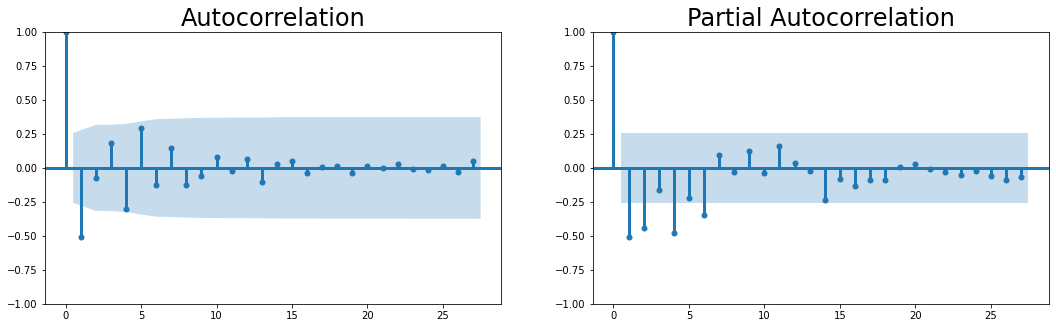

(-2.85772160275304,
 0.050489922175497914,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2148.198472386424)

In [36]:
diff_1 = train_df["GDP"].diff().dropna()
plot_acf_pacf(diff_1.diff().dropna())
adfuller(diff_1.diff().dropna())

Вторые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

In [37]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP"].dropna(), order=(2, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   60
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1360.996
Date:                Thu, 27 Jul 2023   AIC                           2729.992
Time:                        20:53:30   BIC                           2738.233
Sample:                    01-01-1960   HQIC                          2733.202
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2593      0.224     -1.158      0.247      -0.698       0.180
ar.L2         -0.2180      0.284     -0.769      0.442      -0.774       0.338
ma.L1         -0.8251      0.122     -6.768      0.000      -1.064      -0.586
sigma2      1.819e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               358.73
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):             268.76   Skew:                             1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+56. Standard errors may be unstable.
"""

In [38]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP"] = data["GDP"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP"]

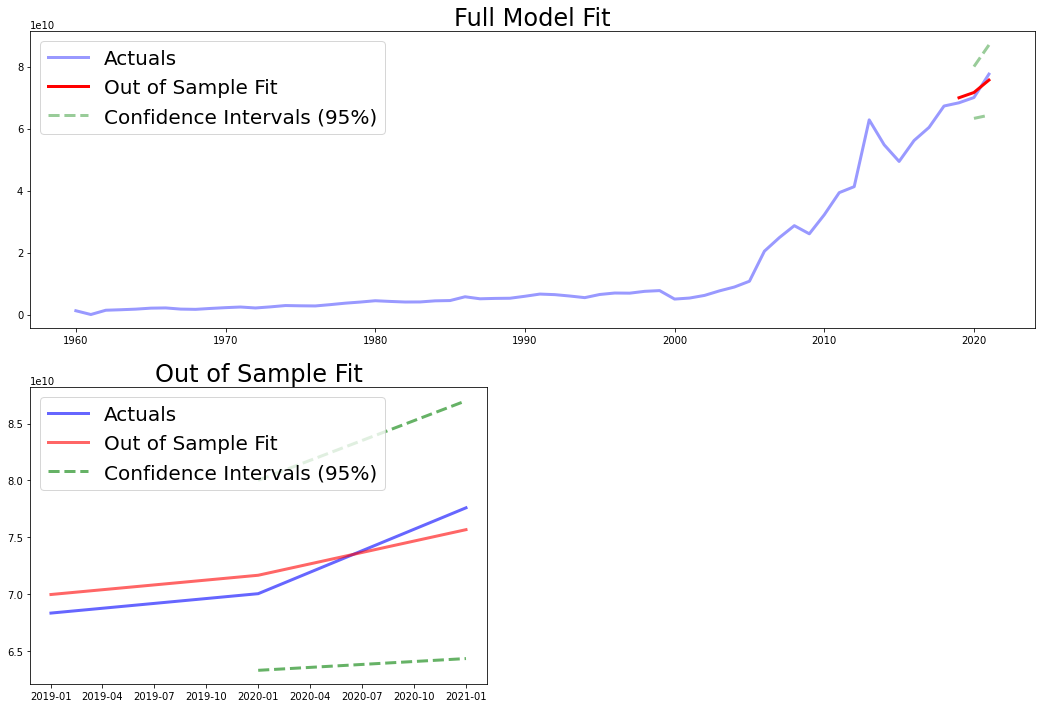

In [39]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [40]:
# pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=6,
    max_q=6,
    D=2,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,2,1)[5]             : AIC=2308.894, Time=0.07 sec
 ARIMA(0,2,0)(0,2,0)[5]             : AIC=2354.689, Time=0.01 sec
 ARIMA(1,2,0)(1,2,0)[5]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,1)(0,2,1)[5]             : AIC=2313.928, Time=0.05 sec
 ARIMA(1,2,1)(0,2,0)[5]             : AIC=2317.707, Time=0.04 sec
 ARIMA(1,2,1)(1,2,1)[5]             : AIC=2307.191, Time=0.10 sec
 ARIMA(1,2,1)(1,2,0)[5]             : AIC=2311.351, Time=0.21 sec
 ARIMA(1,2,1)(2,2,1)[5]             : AIC=2305.293, Time=0.35 sec
 ARIMA(1,2,1)(2,2,0)[5]             : AIC=2304.886, Time=0.42 sec
 ARIMA(0,2,1)(2,2,0)[5]             : AIC=2310.115, Time=0.21 sec
 ARIMA(1,2,0)(2,2,0)[5]             : AIC=inf, Time=0.28 sec
 ARIMA(2,2,1)(2,2,0)[5]             : AIC=2287.637, Time=0.41 sec
 ARIMA(2,2,1)(1,2,0)[5]             : AIC=2302.090, Time=0.10 sec
 ARIMA(2,2,1)(2,2,1)[5]             : AIC=2285.533, Time=0.39 sec
 ARIMA(2,2,1)(1,2,1)[5]             : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(2, 2, 0)x(2, 2, [1], 5)   Log Likelihood               -1136.312
Date:                             Thu, 27 Jul 2023   AIC                           2284.624
Time:                                     20:53:38   BIC                           2295.851
Sample:                                 01-01-1960   HQIC                          2288.867
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8392      0.207     -4.048      0.000      -1.246      -0.433
ar.L2         -0.5320      0.219     -2.428      0.015      -0.961      -0.103
ar.S.L5       -0.9960      0.751     -1.327      0.185      -2.467       0.475
ar.S.L10      -1.0000      0.984     -1.017      0.309      -2.928       0.928
ma.S.L5       -0.5113      0.695     -0.736      0.462      -1.874       0.851
sigma2      3.685e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                42.60
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):              78.12   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+54. Standard errors may be unstable.
"""